In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

import pandas as pd

# Classification

Loading data

In [2]:
# loading data
data = pd.read_csv('../data/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# info about dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


In this dataset on 118 microchips (objects), there are results for two tests of quality control (two numerical variables) and information whether the microchip went into production. Variables are already centered, meaning that the column values have had their own mean values subtracted. Thus, the "average" microchip corresponds to a zero value in the test results.

Let's inspect at the first and last 5 lines.

In [3]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [5]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Data manipulation with Pandas

In [6]:
data.loc[1:10, 'released']

1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
Name: released, dtype: int64

In [7]:
data.iloc[[0, 3], :]

,test1,test2,released
0,0.051267,0.69956,1
3,-0.375000,0.50219,1


Put training data and class labels into separate numpy arrays

In [8]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values

As an intermediate step, we can plot the data. Orange points correspond to defective chips, blue to normal ones.

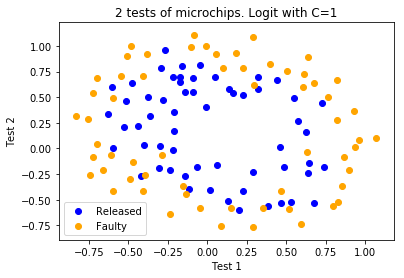

In [9]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=1')
plt.legend();

Let's define a function to display the separating curve of the classifier.

In [10]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # to every point from [x_min, m_max]x[y_min, y_max]
    # we put in correspondence its own color
    if poly_featurizer == None:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Split our data into train and test

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's train logistic regression with regularization parameter $C = 1$- without regularization.

In [13]:
C=1

We will use `sklearn`'s implementation of logistic regression.

In [14]:
from sklearn.linear_model import LogisticRegression

In [15]:
logit = LogisticRegression(random_state=17)

In [16]:
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy on training set: 0.574
Accuracy on testing set: 0.375


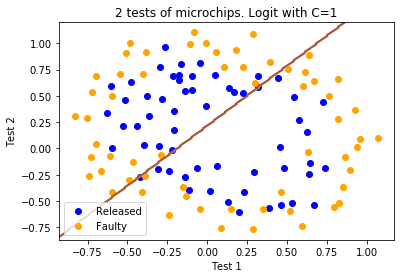

In [17]:
plot_boundary(logit, X, y, grid_step=.01)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_train, y_train), 3))

print("Accuracy on testing set:", 
      round(logit.score(X_test, y_test), 3))

Let's calculate and plot ROC AUC

In [18]:
from sklearn.metrics import roc_curve, auc

In [19]:
def roc(clf, X_test):
    probas_ = logit.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2)
    plt.title('ROC AUC = %0.2f' % roc_auc)

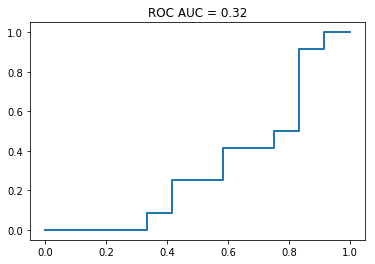

In [20]:
roc(logit, X_test)

As we can see our classifier is not very good since the bounday is nonlinear.

So, we create an object that will add polynomial features up to degree 7 to matrix $X$.

We define the following polynomial features of degree $d$ for two variables $x_1$ and $x_2$:

$$\large \{x_1^d, x_1^{d-1}x_2, \ldots x_2^d\} =  \{x_1^ix_2^j\}_{i+j=d, i,j \in \mathbb{N}}$$

For example, for $d=3$, this will be the following features:

$$\large 1, x_1, x_2,  x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$$


In [21]:
from sklearn.preprocessing import PolynomialFeatures

In [22]:
poly = PolynomialFeatures(degree=7)
X_poly = poly.fit_transform(X)

In [23]:
X_poly.shape

(118, 36)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [25]:
C = 1e-2
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Accuracy on training set: 0.649
Accuracy on testing set: 0.583


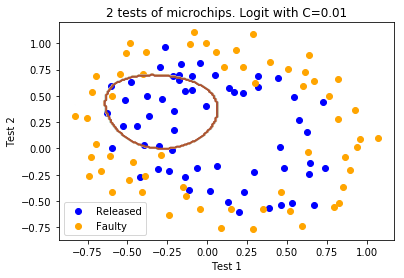

In [26]:
plot_boundary(logit, X, y, grid_step=.01, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_train, y_train), 3))

print("Accuracy on testing set:", 
      round(logit.score(X_test, y_test), 3))

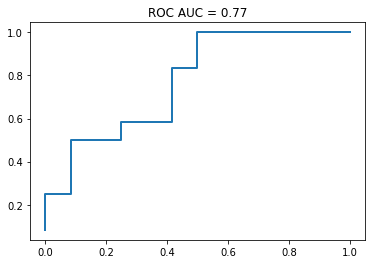

In [27]:
roc(logit, X_test)

We could now try increasing $C$ to 1. In doing this, we weaken regularization, and the solution can now have greater values (in absolute value) of model weights than previously. Now the accuracy of the classifier on the training set improves to 0.831.

Accuracy on training set: 0.787
Accuracy on testing set: 0.833


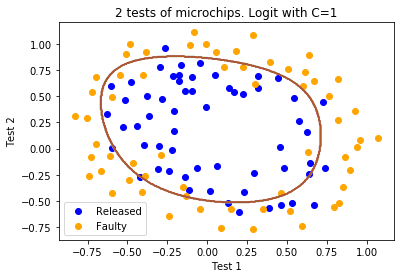

In [28]:
C = 1
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_train, y_train)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_train, y_train), 3))

print("Accuracy on testing set:", 
      round(logit.score(X_test, y_test), 3))

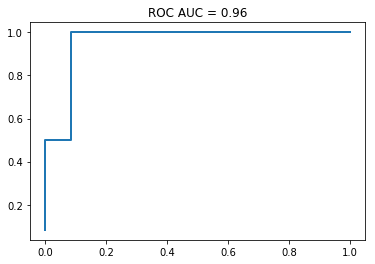

In [29]:
roc(logit, X_test)

Then, why don't we increase $C$ even more - up to 10,000? Now, regularization is clearly not strong enough, and we see overfitting. Note that, with $C$=1 and a "smooth" boundary, the share of correct answers on the training set is not much lower than here. But one can easily imagine how our second model will work much better on new data.

Accuracy on training set: 0.872
Accuracy on testing set: 0.792


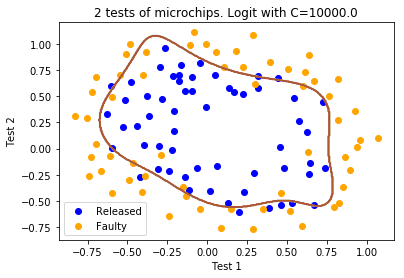

In [30]:
C = 1e4
logit = LogisticRegression(C=C, random_state=17)
logit.fit(X_train, y_train)

plot_boundary(logit, X, y, grid_step=.005, poly_featurizer=poly)

plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.title('2 tests of microchips. Logit with C=%s' % C)
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_train, y_train), 3))

print("Accuracy on testing set:", 
      round(logit.score(X_test, y_test), 3))

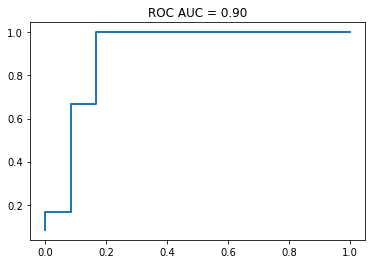

In [31]:
roc(logit, X_test)

To discuss the results, let's rewrite the function that is optimized in logistic regression with the form:

$$\large J(X,y,w) = \mathcal{L} + \frac{1}{C}||w||^2,$$

where

- $\mathcal{L}$ is the logistic loss function summed over the entire dataset
- $C$ is the reverse regularization coefficient (the very same $C$ from `sklearn`'s implementation of `LogisticRegression`)

**Subtotals**:
- the larger the parameter $C$, the more complex the relationships in the data that the model can recover (intuitively $C$ corresponds to the "complexity" of the model - model capacity)
- if regularization is too strong i.e. the values of $C$ are small, the solution to the problem of minimizing the logistic loss function may be the one where many of the weights are too small or zeroed. The model is also not sufficiently "penalized" for errors (i.e. in the function $J$, the sum of the squares of the weights "outweighs", and the error $\mathcal{L}$ can be relatively large). In this case, the model will underfit as we saw in our first case.
- on the contrary, if regularization is too weak i.e. the values of $C$ are large, a vector $w$ with high absolute value components can become the solution to the optimization problem. In this case, $\mathcal{L}$ has a greater contribution to the optimized functional $J$. Loosely speaking, the model is too "afraid" to be mistaken on the objects from the training set and will therefore overfit as we saw in the third case.
- logistic regression will not "understand" (or "learn") what value of $C$ to choose as it does with the weights $w$. That is to say, it can not be determined by solving the optimization problem in logistic regression. We have seen a similar situation before -- a decision tree can not "learn" what depth limit to choose during the training process. Therefore, $C$ is the a model hyperparameter that is tuned on cross-validation; so is the max_depth in a tree.

# More complicated data

Let's work with dataset where given various features of the flight we are asked to predict wheather there will be a delay.

In [32]:
data = pd.read_csv("../data/flight_delays.csv")

Split features and target

In [33]:
X, y = data.iloc[:, :-1], data.iloc[:, -1]

Since we have a lot of categorical features it is a good idea to onehotencode them

In [35]:
X = pd.get_dummies(X)

In [36]:
X.head()

,DepTime,Distance,Month_c-1,Month_c-10,Month_c-11,Month_c-12,Month_c-2,Month_c-3,Month_c-4,Month_c-5,...,Dest_TYS,Dest_VCT,Dest_VIS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YUM
0,1934,732,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1548,834,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1422,416,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1015,872,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1828,423,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We also need to encode our labels to be 0 or 1

In [37]:
from sklearn.preprocessing import LabelEncoder

In [38]:
coder = LabelEncoder()

In [39]:
coder.fit(y)

LabelEncoder()

In [40]:
y = coder.transform(y)

# Your task

Fit `sklearn` implementation of `SGDClassifier` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn-linear-model-sgdclassifier). You also have to split dataset appropriately to the train and test sets and plot ROC curve and AUC. 

# Bonus task

Use cross-validation to choose appropriate constant for regularization coefficient $C$ for $L2$ regularizer (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)